# ロボットマニピュレータの逆運動学を4×4マトリクスを用いて解く！！！

Created by Hiroki Miyamoto 

Modified by Masahiro Furukawa, Aug 18, 2020

8/18現在，下記DHパラメータ表は更新されていないため参照不可．リンクパラメータもDHパラメータに準拠していない(古川)．

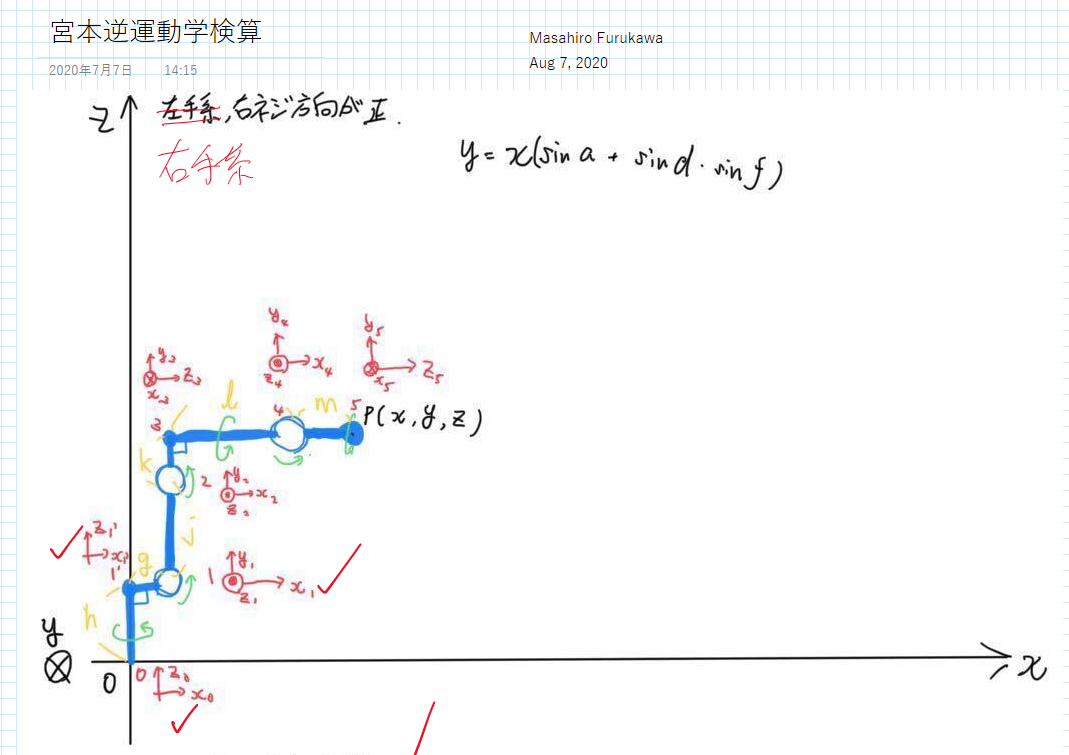

In [4]:
#参考URL -> https://qiita.com/tibigame/items/61cecf86fc978628bfee
#参考図書 -> ポールのロボット・マニピュレータ

import numpy as np
import sympy as sym
sym.init_printing()
Pi = sym.S.Pi # 円周率
E = sym.S.Exp1 # 自然対数の底
I = sym.S.ImaginaryUnit # 虚数単位

#sympyの円周率の方を使うことをすすめる（こっちの方が量子化誤差が大きくなる．numpyも同様に大きい）
import math
pi = math.pi

# 使用する変数の定義(小文字1文字は全てシンボルとする)
(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z) = sym.symbols('a b c d e f g h i j k l m n o p q r s t u v w x y z')
#a～fは角度変数

(n_x, n_y, n_z, o_x, o_y, o_z, a_x, a_y, a_z, p_x, p_y, p_z) = sym.symbols('n_x, n_y, n_z, o_x, o_y, o_z, a_x, a_y, a_z, p_x, p_y, p_z')


In [5]:
#sin.cosの簡易記述用
def S(a):
    return sym.sin(a)

def C(a):
    return sym.cos(a)

In [6]:
#回転・並進行列
def rotx(a):
    return sym.Matrix([[1, 0, 0, 0], [0, C(a), -S(a), 0], [0, S(a), C(a), 0], [0, 0, 0, 1]])

def roty(a):
    return sym.Matrix([[C(a), 0, S(a), 0], [0, 1, 0, 0], [-S(a), 0, C(a), 0], [0, 0, 0, 1]])

def rotz(a):
    return sym.Matrix([[C(a), -S(a), 0, 0], [S(a), C(a), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def trans(x, y, z):
    return sym.Matrix([[1, 0, 0, x], [0, 1, 0, y], [0, 0, 1, z], [0, 0, 0, 1]])


### DH法に基づく座標系間の関係表現

|座標系 i|Z_i-1軸回りに角度θ_i|Z_i-1に沿って距離d_iだけ並進|回転後のX_i-1 (=X_i)に沿って長さa_iだけ並進|X_i軸周りにねじれ角α_iだけ回転|
|-|-|-|-|-|
|1|a|h|g|Pi/2|
|2|b|0|0|0|(yにj)
|3|c|0|-k|-Pi/2|(cの初期位置は-Pi/2)
|4|d|l|0|Pi/2|
|5|e|0|0|-Pi/2|(yにm)
|6|f|n|0|0|

座標系0→1：
Z0軸方向にd1だけ平行移動してから、関節１の関節角度θ1だけ回転、a1=0、α1=0

座標系1→2：
X1軸方向にa2移動、関節２の角度θ2だけ回転、α2=0、d2=0

座標系2→3：
X2軸方向にa3移動、X2軸回りにα3=180度(π)回転、回転後のZ2軸方向(鉛直下向)にd3移動、θ3=0

座標系3→4：
Z0軸方向にd1だけ平行移動してから、関節１の関節角度θ1だけ回転、a1=0、α1=0

座標系4→5：
X1軸方向にa2移動、関節２の角度θ2だけ回転、α2=0、d2=0

座標系5→6：
X2軸方向にa3移動、X2軸回りにα3=180度(π)回転、回転後のZ2軸方向(鉛直下向)にd3移動、θ3=0

### 変換行列 A1 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

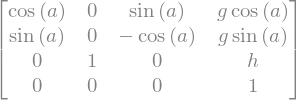

In [7]:
A1=rotz(a)*trans(g,0,h)*rotx(Pi/2)
sym.trigsimp(A1)

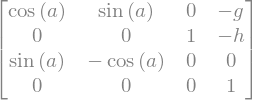

In [8]:
# 逆行列  A1inv
A1inv=rotx(-Pi/2)*trans(-g,0,-h)*rotz(-a)
sym.trigsimp(A1inv)

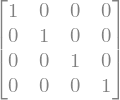

In [9]:
# 逆行列をかけると単位行列になることの確認
ret = A1inv*A1
sym.trigsimp(ret)

### 変換行列 A2 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）


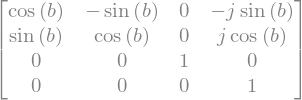

In [10]:
A2=rotz(b)*trans(0,j,0)
sym.trigsimp(A2)

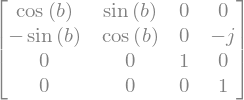

In [11]:
# 逆行列  A2inv
A2inv=trans(0,-j,0)*rotz(-b)
sym.trigsimp(A2inv)

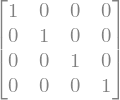

In [12]:
# 逆行列をかけると単位行列になることの確認
ret = A2inv*A2
sym.trigsimp(ret)

### 変換行列 A3 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）



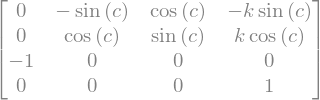

In [13]:
A3=rotz(c)*trans(0,k,0)*roty(Pi/2)
sym.trigsimp(A3)

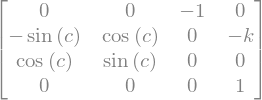

In [14]:
# 逆行列  A3inv
A3inv=roty(-Pi/2)*trans(0,-k,0)*rotz(-c)
sym.trigsimp(A3inv)

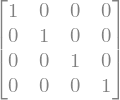

In [15]:
# 逆行列をかけると単位行列になることの確認
ret = A3inv*A3
sym.trigsimp(ret)

### 変換行列 A4 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

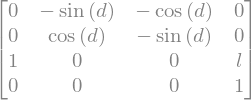

In [16]:
A4=rotz(d)*trans(0,0,l)*roty(-Pi/2)
sym.trigsimp(A4)

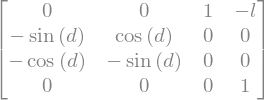

In [17]:
# 逆行列  A4inv
A4inv=roty(Pi/2)*trans(0,0,-l)*rotz(-d)
sym.trigsimp(A4inv)

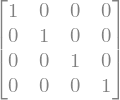

In [18]:
# 逆行列をかけると単位行列になることの確認
ret = A4inv*A4
sym.trigsimp(ret)

### 変換行列 A5 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

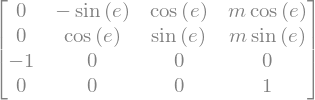

In [19]:
A5=rotz(e)*trans(m,0,0)*roty(Pi/2)
sym.trigsimp(A5)

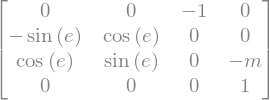

In [20]:
# 逆行列  A5inv
A5inv=roty(-Pi/2)*trans(-m,0,0)*rotz(-e)
sym.trigsimp(A5inv)

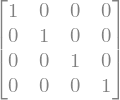

In [21]:
# 逆行列をかけると単位行列になることの確認
ret = A5inv*A5
sym.trigsimp(ret)

### 変換行列 A6 の指定（1.モーターによる回転成分 -> 2.機構に基づく並進成分 -> 3.機構に基づく座標系の回転）

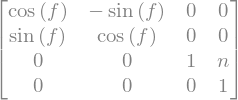

In [22]:
A6=rotz(f)*trans(0,0,n)
sym.trigsimp(A6)

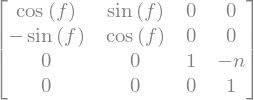

In [23]:
# 逆行列  A6inv
A6inv=trans(0,0,-n)*rotz(-f)
sym.trigsimp(A6inv)

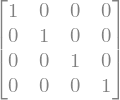

In [24]:
# 逆行列をかけると単位行列になることの確認
ret = A6inv*A6
sym.trigsimp(ret)

# 逆運動学

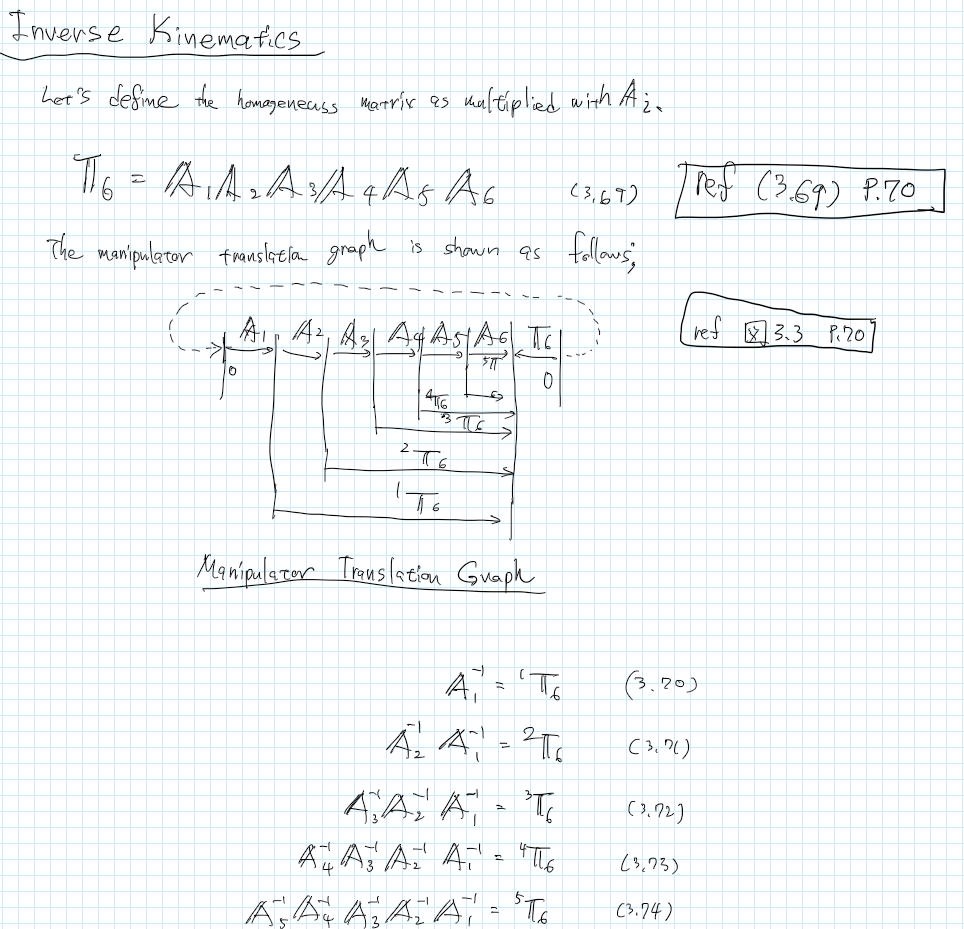

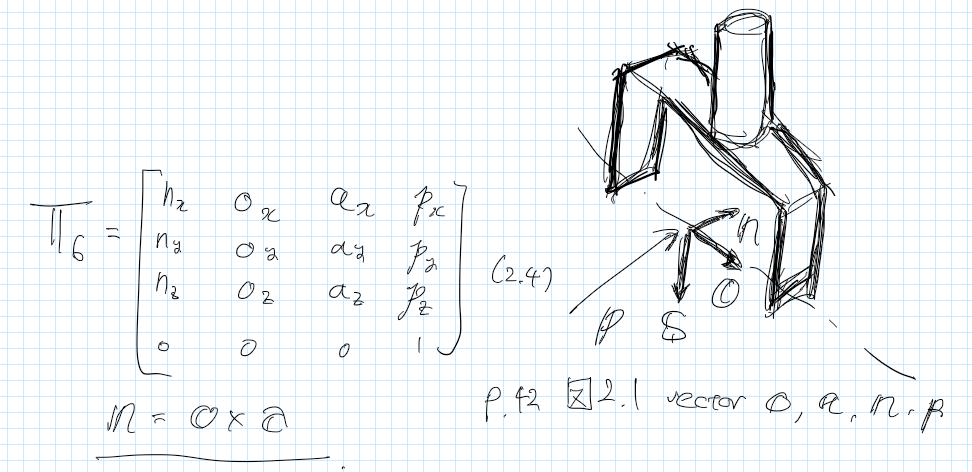

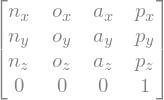

In [25]:
T6=sym.Matrix([[n_x, o_x, a_x, p_x], [n_y, o_y, a_y, p_y], [n_z, o_z, a_z, p_z], [0, 0, 0, 1]])
T6

In [26]:
A56 = sym.trigsimp( A5*A6 )
A456 = sym.trigsimp( A4*A5*A6 )
A3456 = sym.trigsimp( A3*A4*A5*A6 )
A23456 = sym.trigsimp( A2*A3*A4*A5*A6 )
T  = sym.trigsimp( A1*A2*A3*A4*A5*A6 )

T16 = sym.trigsimp(                         A1inv*T6 ) #  eq(3.70)
T26 = sym.trigsimp(                   A2inv*A1inv*T6 ) #  eq(3.71)
T36 = sym.trigsimp(             A3inv*A2inv*A1inv*T6 ) #  eq(3.72)
T46 = sym.trigsimp(       A4inv*A3inv*A2inv*A1inv*T6 ) #  eq(3.73)
T56 = sym.trigsimp( A5inv*A4inv*A3inv*A2inv*A1inv*T6 ) #  eq(3.74)

#x,y,zの順運動学が確認したければここを表示して，Tの４列目を確認
#sym.trigsimp(T*trans(n,0,0))

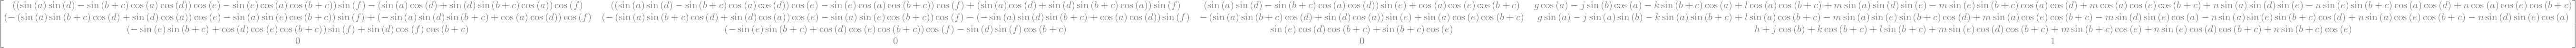

In [27]:
T

### 順運動学計算用Cソースコードを得る

In [28]:
# Masahiro Furukawa
# Aug, 17, 2020
#
# refernce : https://qiita.com/JmpM/items/4bea4997aaf406cca3b4

# Cソースを得る
for ii in range(4):
    for jj in range(4):
        idx = jj*4+ii
        code = sym.ccode(T[idx],assign_to=('Trans['+str(jj)+']['+str(ii)+']'), standard='C89')
        print(code)
    print()

Trans[0][0] = ((sin(a)*sin(d) - sin(b + c)*cos(a)*cos(d))*cos(e) - sin(e)*cos(a)*cos(b + c))*sin(f) - (sin(a)*cos(d) + sin(d)*sin(b + c)*cos(a))*cos(f);
Trans[1][0] = (-(sin(a)*sin(b + c)*cos(d) + sin(d)*cos(a))*cos(e) - sin(a)*sin(e)*cos(b + c))*sin(f) + (-sin(a)*sin(d)*sin(b + c) + cos(a)*cos(d))*cos(f);
Trans[2][0] = (-sin(e)*sin(b + c) + cos(d)*cos(e)*cos(b + c))*sin(f) + sin(d)*cos(f)*cos(b + c);
Trans[3][0] = 0;
()
Trans[0][1] = ((sin(a)*sin(d) - sin(b + c)*cos(a)*cos(d))*cos(e) - sin(e)*cos(a)*cos(b + c))*cos(f) + (sin(a)*cos(d) + sin(d)*sin(b + c)*cos(a))*sin(f);
Trans[1][1] = (-(sin(a)*sin(b + c)*cos(d) + sin(d)*cos(a))*cos(e) - sin(a)*sin(e)*cos(b + c))*cos(f) - (-sin(a)*sin(d)*sin(b + c) + cos(a)*cos(d))*sin(f);
Trans[2][1] = (-sin(e)*sin(b + c) + cos(d)*cos(e)*cos(b + c))*cos(f) - sin(d)*sin(f)*cos(b + c);
Trans[3][1] = 0;
()
Trans[0][2] = (sin(a)*sin(d) - sin(b + c)*cos(a)*cos(d))*sin(e) + cos(a)*cos(e)*cos(b + c);
Trans[1][2] = -(sin(a)*sin(b + c)*cos(d) + sin(d)*cos(a))*

# inverse kinematics

$$
    % reference : https://qiita.com/namoshika/items/63db972bfd1030f8264a
    % 空白は表示に影響しない。コメントは"%"で始める
    % 下付き文字は"_a"、上付き文字は"^a"
    % 改行は"\\"を付ける
    {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    \boldsymbol{A}_2 
    \boldsymbol{A}_3 
    \boldsymbol{A}_4 
    \boldsymbol{A}_5 
    \boldsymbol{A}_6 　　　(3.75)\\
    {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    ^{1}\boldsymbol{T}_6   　　　(3.76)
    % 複数文字を1要素とする際は{...}で囲う
    % 空白は"\quad"
$$

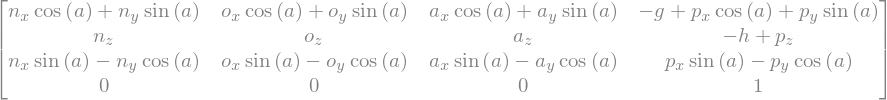

In [29]:
# Left hand  of (3.76)
A1iT6 = T16
A1iT6

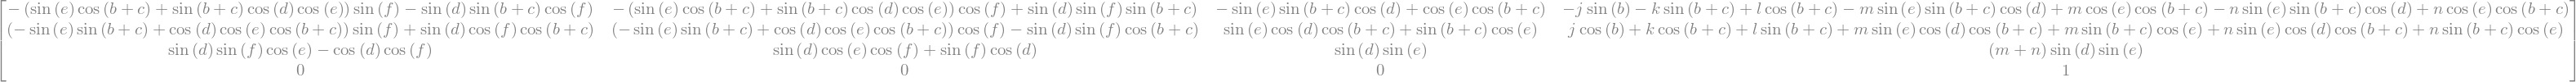

In [30]:
# Right hand of (3.76)
A23456

In [31]:
# eq1 (3.76)
sym.Eq(A1iT6[10] , A23456[10])

In [32]:
# eq2 (3.76)
sym.Eq(A1iT6[11] , A23456[11])

In [33]:
# eq1 (3.76)
sym.Eq(A1iT6[8] , A23456[8])

In [34]:
# eq2 (3.76)
sym.Eq(A1iT6[9] , A23456[9])

### 

$$
    % reference : https://qiita.com/namoshika/items/63db972bfd1030f8264a
    % 空白は表示に影響しない。コメントは"%"で始める
    % 下付き文字は"_a"、上付き文字は"^a"
    % 改行は"\\"を付ける
    {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    \boldsymbol{A}_3 
    \boldsymbol{A}_4 
    \boldsymbol{A}_5 
    \boldsymbol{A}_6 　　\\
    {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    ^{2}\boldsymbol{T}_6   　　
    % 複数文字を1要素とする際は{...}で囲う
    % 空白は"\quad"
$$


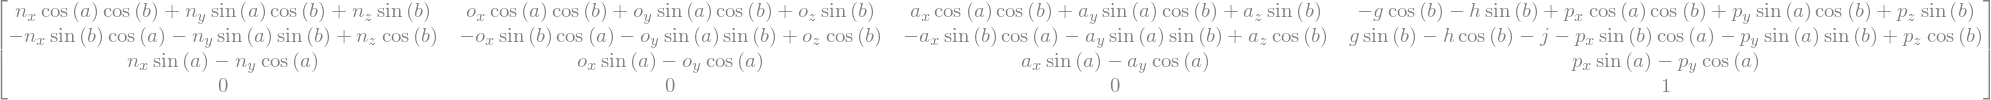

In [35]:
# Left hand  
A2iA1iT6 = T26
A2iA1iT6

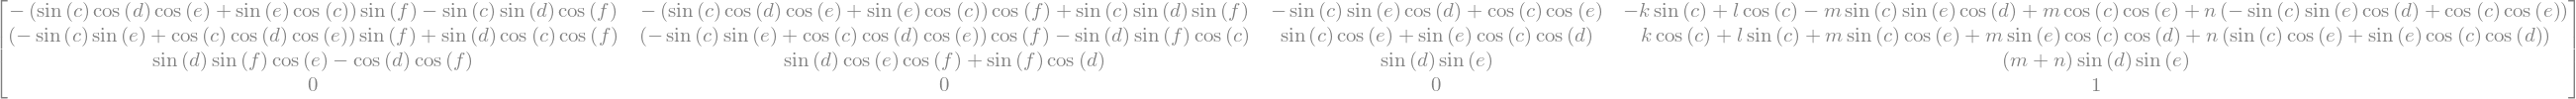

In [36]:
A3456

In [37]:
idx = 8
sym.Eq(A2iA1iT6[idx] , A3456[idx])

In [38]:
idx = 9
sym.Eq(A2iA1iT6[idx] , A3456[idx])

### 

$$
    % reference : https://qiita.com/namoshika/items/63db972bfd1030f8264a
    % 空白は表示に影響しない。コメントは"%"で始める
    % 下付き文字は"_a"、上付き文字は"^a"
    % 改行は"\\"を付ける
    {\boldsymbol{A}_{3}}^{-1} {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    \boldsymbol{A}_4 
    \boldsymbol{A}_5 
    \boldsymbol{A}_6 　　\\
    {\boldsymbol{A}_{3}}^{-1} {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    ^{3}\boldsymbol{T}_6   　　
    % 複数文字を1要素とする際は{...}で囲う
    % 空白は"\quad"
$$


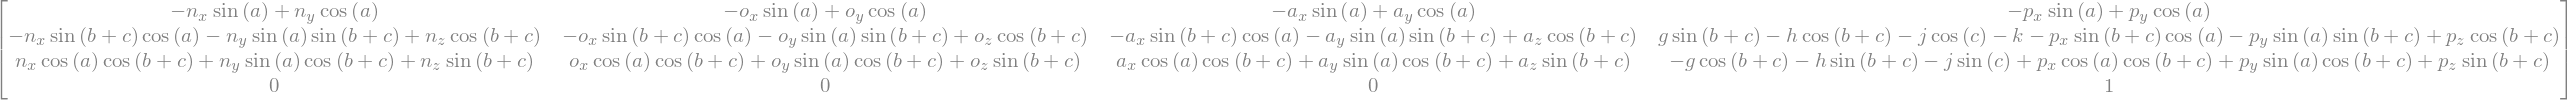

In [39]:
# Left hand  
A3iA2iA1iT6 = T36
A3iA2iA1iT6

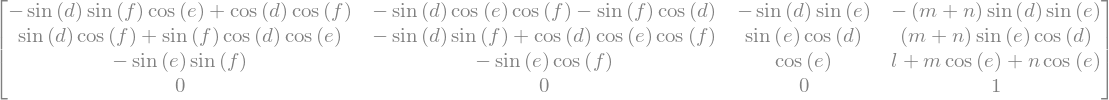

In [40]:
A456

In [41]:
idx = 3
sym.Eq(A3iA2iA1iT6[idx] , A456[idx])

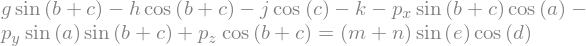

In [42]:
idx = 7
sym.Eq(A3iA2iA1iT6[idx] , A456[idx])

In [43]:
idx = 10
sym.Eq(A3iA2iA1iT6[idx] , A456[idx])

### 

$$
    % reference : https://qiita.com/namoshika/items/63db972bfd1030f8264a
    % 空白は表示に影響しない。コメントは"%"で始める
    % 下付き文字は"_a"、上付き文字は"^a"
    % 改行は"\\"を付ける
    {\boldsymbol{A}_{4}}^{-1} {\boldsymbol{A}_{3}}^{-1} {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    \boldsymbol{A}_5 
    \boldsymbol{A}_6 　　\\
    {\boldsymbol{A}_{4}}^{-1} {\boldsymbol{A}_{3}}^{-1} {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    ^{4}\boldsymbol{T}_6   　　
    % 複数文字を1要素とする際は{...}で囲う
    % 空白は"\quad"
$$


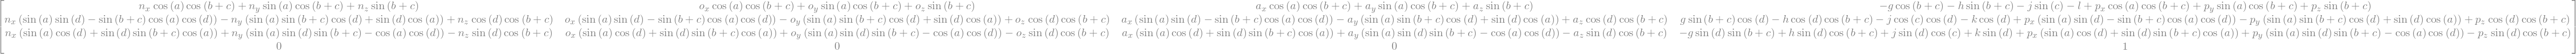

In [44]:
# Left hand  
A4iA3iA2iA1iT6 = T46
A4iA3iA2iA1iT6

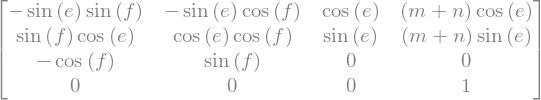

In [45]:
A56

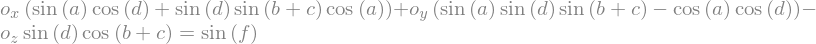

In [46]:
idx = 9
sym.Eq(A4iA3iA2iA1iT6[idx] , A56[idx])

### 

$$
    % reference : https://qiita.com/namoshika/items/63db972bfd1030f8264a
    % 空白は表示に影響しない。コメントは"%"で始める
    % 下付き文字は"_a"、上付き文字は"^a"
    % 改行は"\\"を付ける
    {\boldsymbol{A}_{5}}^{-1} {\boldsymbol{A}_{4}}^{-1} {\boldsymbol{A}_{3}}^{-1} {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    \boldsymbol{A}_6 　　\\
    {\boldsymbol{A}_{5}}^{-1} {\boldsymbol{A}_{4}}^{-1} {\boldsymbol{A}_{3}}^{-1} {\boldsymbol{A}_{2}}^{-1} {\boldsymbol{A}_{1}}^{-1} \boldsymbol{T}_6 = 
    ^{5}\boldsymbol{T}_6   　　
    % 複数文字を1要素とする際は{...}で囲う
    % 空白は"\quad"
$$


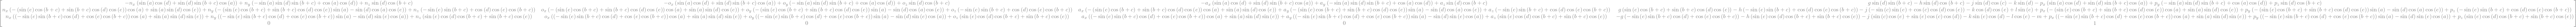

In [47]:
# Left hand  
A5iA4iA3iA2iA1iT6 = T56
A5iA4iA3iA2iA1iT6

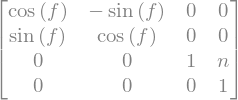

In [48]:
A6

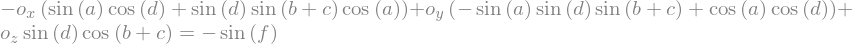

In [49]:
idx = 1
sym.Eq(A5iA4iA3iA2iA1iT6[idx] , A6[idx])

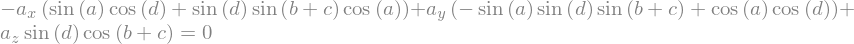

In [50]:
idx = 2
sym.Eq(A5iA4iA3iA2iA1iT6[idx] , A6[idx])

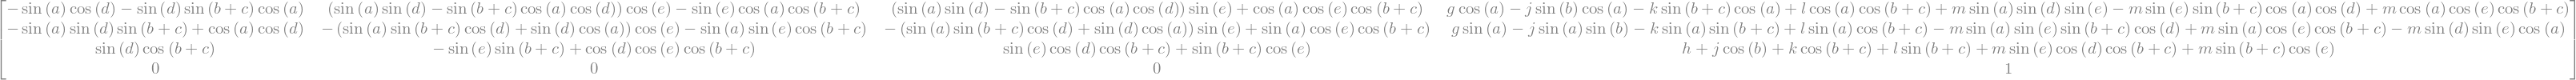

In [51]:
A12345 = sym.trigsimp(A1*A2*A3*A4*A5)
A12345

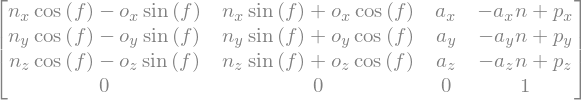

In [52]:
# p.80
T6A6i = sym.trigsimp(T6*A6inv)
T6A6i

In [53]:
idx = 8
sym.Eq(A12345[idx] , T6A6i[idx])

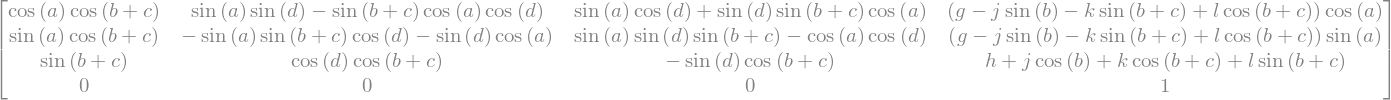

In [54]:
A1234 = sym.trigsimp(A1*A2*A3*A4)
A1234

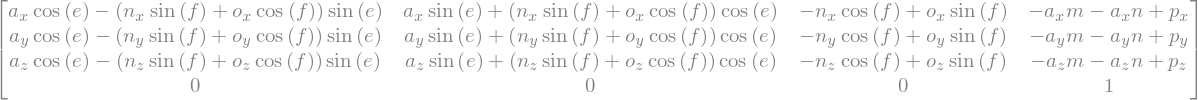

In [55]:
# p.80
T6A6iA5i = sym.trigsimp(T6*A6inv*A5inv)
T6A6iA5i

In [56]:
idx = 8
sym.Eq(A1234[idx] , T6A6iA5i[idx])

In [57]:
idx = 9
sym.Eq(A1234[idx] , T6A6iA5i[idx])

In [58]:
idx = 10
sym.Eq(A1234[idx] , T6A6iA5i[idx])

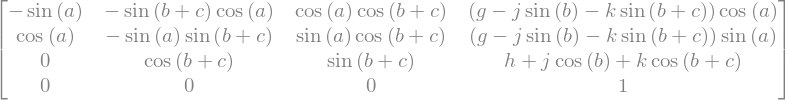

In [59]:
A123 = sym.trigsimp(A1*A2*A3)
A123

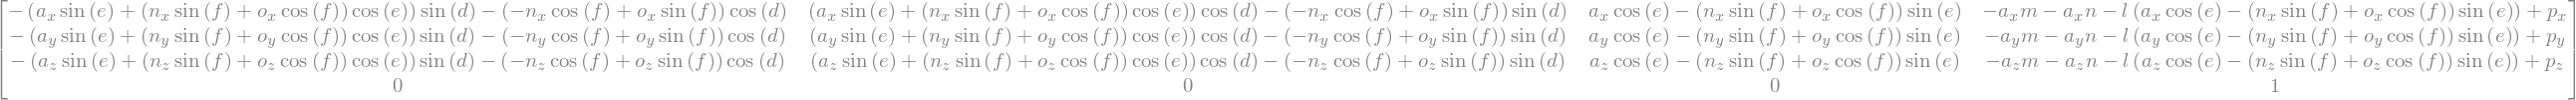

In [60]:
# p.80
T6A6iA5iA4i = sym.trigsimp(T6*A6inv*A5inv*A4inv)
T6A6iA5iA4i

In [72]:
idx = 2
sym.Eq(A123[idx] , T6A6iA5iA4i[idx])

In [74]:
idx = 6
sym.Eq(A123[idx], T6A6iA5iA4i[idx])

In [89]:
idx = 9
sym.Eq(A123[idx], T6A6iA5iA4i[idx])

idx = 10
sym.factor(sym.Eq(A123[idx], T6A6iA5iA4i[idx]), S(b+c))

In [93]:
idx = 10

eq = sym.Eq(A123[idx], T6A6iA5iA4i[idx])
sym.separatevars(eq)

In [97]:
(C_bc, S_bc) = sym.symbols('C_bc, S_bc')

In [96]:
eq.subs(S(b+c),S_bc)

$$
\displaystyle \sin{\left(b + c \right)} = a_{z} \cos{\left(e \right)} - \left(n_{z} \sin{\left(f \right)} + o_{z} \cos{\left(f \right)}\right) \sin{\left(e \right)} \\
\displaystyle - \sin{\left(d \right)} \cos{\left(b + c \right)} = - n_{z} \cos{\left(f \right)} + o_{z} \sin{\left(f \right)} \\
\displaystyle \cos{\left(d \right)} \cos{\left(b + c \right)} = a_{z} \sin{\left(e \right)} + \left(n_{z} \sin{\left(f \right)} + o_{z} \cos{\left(f \right)}\right) \cos{\left(e \right)} \\
\displaystyle \cos{\left(a \right)} \cos{\left(b + c \right)} = a_{x} \cos{\left(e \right)} - \left(n_{x} \sin{\left(f \right)} + o_{x} \cos{\left(f \right)}\right) \sin{\left(e \right)} \\
\displaystyle \sin{\left(a \right)} \cos{\left(b + c \right)} = a_{y} \cos{\left(e \right)} - \left(n_{y} \sin{\left(f \right)} + o_{y} \cos{\left(f \right)}\right) \sin{\left(e \right)} \\
\displaystyle \cos{\left(d \right)} \cos{\left(b + c \right)} = a_{z} \sin{\left(e \right)} + \left(n_{z} \sin{\left(f \right)} + o_{z} \cos{\left(f \right)}\right) \cos{\left(e \right)} \\
$$